<a href="https://colab.research.google.com/github/p2327/CS61a_Berkeley/blob/master/ML0101EN_Proj_Loan_py_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [241]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-07-31 22:33:43--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.01s   

2019-07-31 22:33:44 (1.76 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [242]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [243]:
df.shape

(346, 10)

### Convert to date time object 

In [244]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [245]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [0]:
# notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y
import seaborn as sns

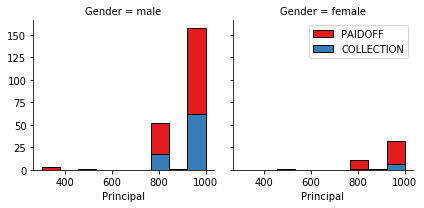

In [247]:
# import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

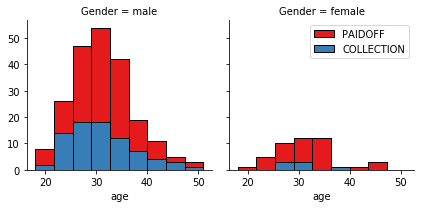

In [248]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

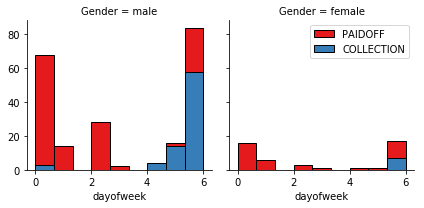

In [249]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [250]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [251]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [252]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [253]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [254]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [255]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [256]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [257]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

**Preparing data**

In [258]:
XKNN = Feature.values
XKNN[0:5]

array([[1000,   30,   45,    0,    0,    0,    1,    0],
       [1000,   30,   33,    1,    0,    1,    0,    0],
       [1000,   15,   27,    0,    0,    0,    0,    1],
       [1000,   30,   28,    1,    1,    0,    0,    1],
       [1000,   30,   29,    0,    1,    0,    0,    1]])

In [259]:
XKNN = preprocessing.StandardScaler().fit(XKNN).transform(XKNN.astype(float))
XKNN[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

**Using train, test split method holding out 20% of the dataset as test**

In [260]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XKNN, y, test_size=0.2)
print('Train set:', X_train.shape,  y_train.shape)
print('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


**Fitting a model with k=2**

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [262]:
k = 2
 
knn_fit = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
knn_fit

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

**Prediction on held out data and accuracy measure**

In [263]:
knn_pred = knn_fit.predict(X_test)
knn_pred[0:5]
                          

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF'],
      dtype=object)

In [264]:
knn_fit.score(X_test, y_test) # Accuracy of the model on the test data

0.7142857142857143

In [265]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, knn_fit.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, knn_pred))

Train set Accuracy:  0.7898550724637681
Test set Accuracy:  0.7142857142857143


**Obtain a more accurate representation of the model using k-Fold cross-validation**

*Cross validation reduces bias by dividing the set randomly in k groups and rotating validation (one of the k-folds) and training sets (remaining k-1 folds)*

In [266]:
from sklearn.model_selection import cross_val_score
import numpy as np

#train model with cross validation value of 5 (5-folds)
cv_scores = cross_val_score(knn_fit, X, y, cv=5)
#print each cv score (accuracy) and their average
print(cv_scores)
print(f'cv_scores mean:{(np.mean(cv_scores))}')

[0.47142857 0.46376812 0.65217391 0.8115942  0.84057971]
cv_scores mean:0.6479089026915114


**Tuning hyperparametes with GridSearchCV**

*GridSearchCV works by training the model multiple times on a range of parameters as specified in the method arguments*

In [267]:
from sklearn.model_selection import GridSearchCV

#create new a knn model
knn = KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=3)

#fit model to data, GridSearchCV automatically splits into training and test (cross-validation)
knn_gscv.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

**Find the best parameters and score**

In [268]:
knn_gscv.best_params_



{'n_neighbors': 5}

In [269]:
knn_gscv.best_score_

0.7225433526011561

# Decision Tree

**Setting up the decision tree**

In [270]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=4)
tree_clf

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

**Fit the data**

In [271]:
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

**Prediction and accuracy measure**

In [272]:
tree_pred = tree_clf.predict(X_test)
tree_pred[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [273]:
tree_clf.score(X_test, y_test) # Accuracy of the model on the test data

0.7142857142857143

**Using GridSearchCV to find best parameters**

In [274]:
#create new a knn model
t_clf = DecisionTreeClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'class_weight': [None, 'balanced'], # balanced adjusts the weights inversely proportional to class frequencies
              'max_depth': [2, 4, 8, 16, 24, 32] # the deeper the tree, the more split it has
             }

#use gridsearch to test all values for n_neighbors
t_clf_gscv = GridSearchCV(t_clf, param_grid, cv=5)

#fit model to data
t_clf_gscv.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [2, 4, 8, 16, 24, 32]},
             

**Find the best parameters and accuracy score**

In [275]:
t_clf_gscv.best_params_

{'class_weight': 'balanced', 'max_depth': 16}

In [276]:
 t_clf_gscv.best_score_

0.6647398843930635

# Support Vector Machine

**Using GridSearchCv**

* Define a grid of parameters for C, kernel and gamma
* Specify our estimator (in this case Support Vector Machine SV Classifier with gamma=auto)
* Create a grid object with gridsearch for the estimator and the parameters to try
* Fit the object with the data
* Print best estimator based on above

In [277]:
from sklearn import svm

# create a SVM model
svc = svm.SVC()

#Create a dictionary of possible parameters
params_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], # regularization parameter, controls cost of misclassification
          'gamma': [0.0001, 0.001, 0.01, 0.1], # defines how far the influence of a single training example reaches
          'kernel':['rbf', 'linear'] } # kernelling functions to try higher dimensional spaces

#Create the GridSearchCV object
svc_gscv = GridSearchCV(svc, params_grid, cv=5) 

#Fit the data to the GridSearch object
svc_gscv.fit(X, y)

#Print the best estimator with it's parameters
print(svc_gscv.best_estimator_)

SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [278]:
# best parameters

svc_gscv.best_params_

{'C': 0.001, 'gamma': 0.0001, 'kernel': 'rbf'}

In [279]:
# best score

svc_gscv.best_score_

0.7514450867052023

# Logistic Regression

**Using GridSearchCV**

In [280]:
from sklearn.linear_model import LogisticRegression


# create a LR model
logit = LogisticRegression()

#Create a dictionary of possible parameters
params_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], # smaller value specify strogner regularization
               'solver': ['liblinear', 'lbfgs'],
               'max_iter': [200, 400, 800, 1200]
              }

#Create the GridSearchCV object
logit_gscv = GridSearchCV(logit, params_grid, cv=3)

#Fit the data to the GridSearch object
logit_gscv.fit(X, y)

#Print the best estimator with it's parameters
print(logit_gscv.best_estimator_)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [281]:
# best parameters

logit_gscv.best_params_

{'C': 0.001, 'max_iter': 200, 'solver': 'lbfgs'}

In [282]:
# best score

logit_gscv.best_score_

0.7514450867052023

# Model Evaluation using Test set

In [0]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [284]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-07-31 22:33:55--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2019-07-31 22:33:55 (545 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [285]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


Predict the true y found in the load_test.cvs to evaluate the best classifier.

Use jaccard index and other  measures (f1-score and logloss).

**Pre-processing**

In [286]:
# convert dates to datetime
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [287]:
# feature binarization
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [288]:
# convert categorical features to numerical values
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [289]:
# selecting colums of interest
test_df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,50,1,Bechalor
1,300,7,35,0,Master or Above
2,1000,30,43,1,High School or Below
3,1000,30,26,0,college
4,800,15,29,0,Bechalor


In [290]:
# one hot encoding
Test = test_df[['Principal','terms','age','Gender','weekend']]
Test = pd.concat([Test ,pd.get_dummies(df['education'])], axis=1)
Test.drop(['Master or Above'], axis = 1,inplace=True)
Test.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000.0,30.0,50.0,1.0,0.0,0,1,0
1,300.0,7.0,35.0,0.0,1.0,1,0,0
2,1000.0,30.0,43.0,1.0,1.0,0,0,1
3,1000.0,30.0,26.0,0.0,1.0,0,0,1
4,800.0,15.0,29.0,0.0,1.0,0,0,1


In [291]:
# predictors
XT = Test
XT[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000.0,30.0,50.0,1.0,0.0,0,1,0
1,300.0,7.0,35.0,0.0,1.0,1,0,0
2,1000.0,30.0,43.0,1.0,1.0,0,0,1
3,1000.0,30.0,26.0,0.0,1.0,0,0,1
4,800.0,15.0,29.0,0.0,1.0,0,0,1


In [295]:
# response
y_T = test_df['loan_status'].values
y_T[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

**Computing scores**

In [316]:
y_T.shape

(54,)

In [0]:
# giving X same rows as y_T
X_t = X_test[0:54]

In [301]:
# KNN
k_pred = knn_gscv.best_estimator_.predict(X_t)
print("KNN Jaccard index: %.2f" % jaccard_similarity_score(y_T, k_pred[0:54]))
print("KNN F1-score: %.2f" % f1_score(y_T, k_pred, average='weighted') )


KNN Jaccard index: 0.70
KNN F1-score: 0.70


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [302]:
# Decision tree
t_pred = t_clf_gscv.best_estimator_.predict(X_t)
print("Decision Tree Jaccard index: %.2f" % jaccard_similarity_score(y_T, t_pred))
print("Decision Tree F1-score: %.2f" % f1_score(y_T, t_pred, average='weighted') )

KNN Jaccard index: 0.56
KNN F1-score: 0.58


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [304]:
# SVM
sv_pred = svc_gscv.best_estimator_.predict(X_t)
print("SVM Jaccard index: %.2f" % jaccard_similarity_score(y_T, sv_pred))
print("SVM F1-score: %.2f" % f1_score(y_T, sv_pred, average='weighted') )

SVM Jaccard index: 0.74
SVM Tree F1-score: 0.63


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [306]:
# Logistic regression
lr_pred = logit_gscv.best_estimator_.predict(X_t)
print("LR Jaccard index: %.2f" % jaccard_similarity_score(y_T, lr_pred))
print("LR F1-score: %.2f" % f1_score(y_T, lr_pred, average='weighted'))


LR Jaccard index: 0.74
LR F1-score: 0.63


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

In [318]:
# assign names to estimators
knn = knn_gscv.best_estimator_
tree = t_clf_gscv.best_estimator_
svm = svc_gscv.best_estimator_
lr = logit_gscv.best_estimator_



report_df = pd.DataFrame({'Algorithm': ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression']})
report_df.set_index('Algorithm', inplace = True)
report_df['Jaccard'] = list(map(lambda x: jaccard_similarity_score (y_T, x.predict(X_t)), [knn, tree, svm, lr]))
report_df['F1-score'] = list(map(lambda x: f1_score(y_T, x.predict(X_t)), [knn, tree, svm, lr]))
report_df.at['Logistic Regression', 'LogLoss'] = log_loss (y_T, lr.predict_proba(X_t))
report_df

ValueError: ignored

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>